### Data and Libraries
The data for this tutorial can be found from the [NIH Clinical Center Chest X-Ray](https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737) database. In this example, we only utilize the data from images_001.tar.gz, which unzips to about 5K images (~2GB). Also, we download the image labels as [Data_Entry_2017_v2020.csv](https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345). 



- Link Images: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737
- Link Labels: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

In [1]:
# Import libraries for modeling
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.models import load_model
from keras import backend as K

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline

### Augmentation libraries
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# import Augmentor

Using TensorFlow backend.


### Data augmentation sandbox

In [ ]:
# Loading a sample image  
img = load_img('data/image.png')  
# Converting the input sample image to an array 
x = img_to_array(img) 
# Reshaping the input image 
x = x.reshape((1, ) + x.shape)


## Sand box to alter images
# ------------------------------------------------------
## Horizontal Flip
#datagen = ImageDataGenerator(horizontal_flip=True)
## Zoom, Turn, Crop(Shear)
datagen = ImageDataGenerator(rotation_range = 5, shear_range = 0.02, 
                             zoom_range = 0.02, samplewise_center=True,samplewise_std_normalization= True)



# ------------------------------------------------------
i = 0
for batch in datagen.flow(x, batch_size = 1, save_to_dir ='data/preview',save_prefix ='image', save_format ='jpeg'):
    i += 1
    if i > 5:
        break
    

### Data label parsing and split into testing and training

In [2]:
import pandas as pd
df = pd.read_csv("data/Data_Entry_2017_v2020.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [3]:
from glob import glob
files = []
for images in glob("images/*"):
    files.append(images.split("/")[1])
    
df = df[df["Image Index"].isin(files)]

df['labels'] = [x.split("|") for x in df["Finding Labels"]]
from sklearn.preprocessing import MultiLabelBinarizer
# Binarise labels
mlb = MultiLabelBinarizer()
expandedLabelData = mlb.fit_transform(df["labels"])
labelClasses = mlb.classes_

# Create a pandas.DataFrame from our output
expandedLabels = pd.DataFrame(expandedLabelData, columns=labelClasses)
expandedLabels['Images'] = df['Image Index']
expandedLabels['ID'] = df['Patient ID']
#expandedLabels = expandedLabels.set_index("ID")
import random
random.seed(10)
testing = expandedLabels.sample(frac=0.2)
testing_files = testing['Images']
training = expandedLabels[~expandedLabels["Images"].isin(testing_files)]

labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
          'Pneumothorax','Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

### Train model with different data augmentations

#### Create generators to process images

##### Raw images with no augmentation

In [4]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    image_generator = ImageDataGenerator()
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            save_to_dir = "data/test",
            target_size=(target_w,target_h))
    
    return generator



def get_test_and_valid_generator(valid_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Images", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    image_generator = ImageDataGenerator()
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    
    return valid_generator

In [5]:
IMAGE_DIR = "images/"
train_generator = get_train_generator(training, IMAGE_DIR, "Images", labels)
valid_generator = get_test_and_valid_generator(testing, training, IMAGE_DIR, "Images", labels)

Found 3999 validated image filenames.
Found 3999 validated image filenames.
Found 1000 validated image filenames.


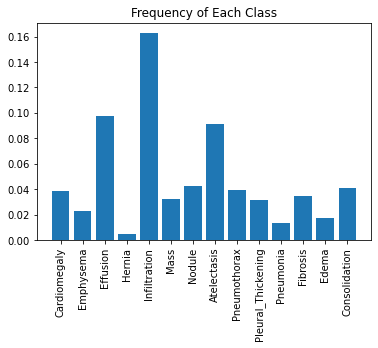

In [6]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [9]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')

Epoch 1/10
100/100 [==============================] - 33s 329ms/step - loss: 1.6764 - val_loss: 2.9243
Epoch 2/10
100/100 [==============================] - 32s 316ms/step - loss: 1.7505 - val_loss: 2.6199
Epoch 3/10
100/100 [==============================] - 31s 308ms/step - loss: 1.5732 - val_loss: 2.2601
Epoch 4/10
100/100 [==============================] - 31s 305ms/step - loss: 1.6135 - val_loss: 2.9774
Epoch 5/10
100/100 [==============================] - 33s 330ms/step - loss: 1.5565 - val_loss: 4.4340
Epoch 6/10
100/100 [==============================] - 31s 306ms/step - loss: 1.6379 - val_loss: 1.5758
Epoch 7/10
100/100 [==============================] - 31s 307ms/step - loss: 1.7120 - val_loss: 2.2921
Epoch 8/10
100/100 [==============================] - 31s 309ms/step - loss: 1.5604 - val_loss: 2.1457
Epoch 9/10
100/100 [==============================] - 31s 307ms/step - loss: 1.5469 - val_loss: 2.5250
Epoch 10/10
100/100 [==============================] - 31s 307ms/step - l

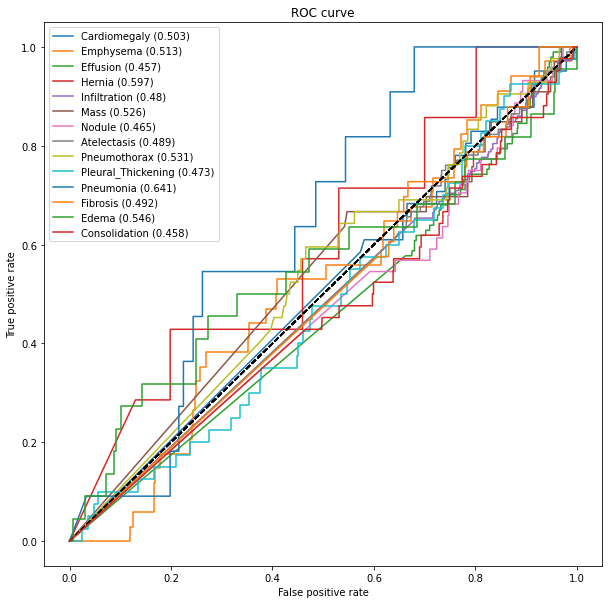

In [10]:
model.fit(train_generator, validation_data=valid_generator,steps_per_epoch=100, validation_steps=25, epochs = 10)

predicted_vals = model.predict(valid_generator, steps = len(valid_generator))

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

auc_rocs = get_roc_curve(labels, predicted_vals, valid_generator)

In [12]:
np.mean(auc_rocs)

0.5121836264929113

In [13]:
df_results = pd.DataFrame(zip(labels, auc_rocs))
df_results.columns = ['Condition', "No Augmentation"]

##### Augmented basic

In [14]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    image_generator = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            save_to_dir = "data/test",
            target_size=(target_w,target_h))
    
    return generator




def get_test_and_valid_generator(valid_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Images", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    image_generator = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    
    return valid_generator

In [15]:
IMAGE_DIR = "images/"
train_generator = get_train_generator(training, IMAGE_DIR, "Images", labels)
valid_generator = get_test_and_valid_generator(testing, training, IMAGE_DIR, "Images", labels)

Found 3999 validated image filenames.
Found 3999 validated image filenames.
Found 1000 validated image filenames.


In [16]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')

Epoch 1/10
100/100 [==============================] - 32s 323ms/step - loss: 1.6810 - val_loss: 2.3108
Epoch 2/10
100/100 [==============================] - 31s 310ms/step - loss: 1.7266 - val_loss: 1.4577
Epoch 3/10
100/100 [==============================] - 31s 311ms/step - loss: 1.5534 - val_loss: 1.9488
Epoch 4/10
100/100 [==============================] - 31s 312ms/step - loss: 1.5495 - val_loss: 1.7018
Epoch 5/10
100/100 [==============================] - 31s 315ms/step - loss: 1.5651 - val_loss: 2.4719
Epoch 6/10
100/100 [==============================] - 31s 314ms/step - loss: 1.5943 - val_loss: 1.6071
Epoch 7/10
100/100 [==============================] - 31s 312ms/step - loss: 1.7166 - val_loss: 2.1391
Epoch 8/10
100/100 [==============================] - 31s 314ms/step - loss: 1.4982 - val_loss: 1.6724
Epoch 9/10
100/100 [==============================] - 31s 311ms/step - loss: 1.5517 - val_loss: 1.6849
Epoch 10/10
100/100 [==============================] - 31s 313ms/step - l

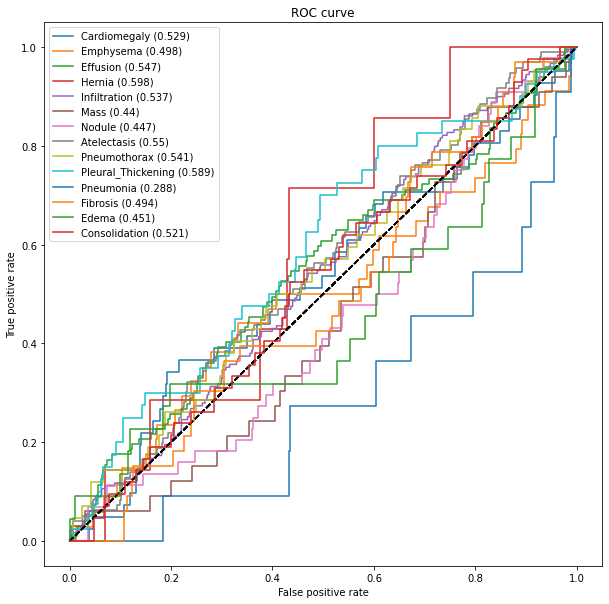

In [17]:
model.fit(train_generator, validation_data=valid_generator,steps_per_epoch=100, validation_steps=25, epochs = 10)

predicted_vals = model.predict(valid_generator, steps = len(valid_generator))

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

auc_rocs = get_roc_curve(labels, predicted_vals, valid_generator)

In [18]:
np.mean(auc_rocs)

0.5022723396823453

In [20]:
df_results['Basic Augmentation'] = auc_rocs

##### Data augmentation crazy!!!

In [21]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    image_generator = ImageDataGenerator(rotation_range = 5, shear_range = 0.02, 
                                         zoom_range = 0.02, samplewise_center=True,
                                         samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            save_to_dir = "data/test",
            target_size=(target_w,target_h))
    
    return generator




def get_test_and_valid_generator(valid_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Images", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    image_generator = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    
    return valid_generator

In [22]:
IMAGE_DIR = "images/"
train_generator = get_train_generator(training, IMAGE_DIR, "Images", labels)
valid_generator = get_test_and_valid_generator(testing, training, IMAGE_DIR, "Images", labels)

Found 3999 validated image filenames.
Found 3999 validated image filenames.
Found 1000 validated image filenames.


In [23]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')

Epoch 1/10
100/100 [==============================] - 42s 419ms/step - loss: 1.6761 - val_loss: 4.7102
Epoch 2/10
100/100 [==============================] - 40s 405ms/step - loss: 1.7493 - val_loss: 1.8536
Epoch 3/10
100/100 [==============================] - 41s 407ms/step - loss: 1.5668 - val_loss: 4.3588
Epoch 4/10
100/100 [==============================] - 41s 406ms/step - loss: 1.5714 - val_loss: 2.3625
Epoch 5/10
100/100 [==============================] - 41s 409ms/step - loss: 1.5748 - val_loss: 2.2568
Epoch 6/10
100/100 [==============================] - 41s 407ms/step - loss: 1.6162 - val_loss: 1.8841
Epoch 7/10
100/100 [==============================] - 41s 408ms/step - loss: 1.7426 - val_loss: 1.5481
Epoch 8/10
100/100 [==============================] - 41s 409ms/step - loss: 1.5296 - val_loss: 2.0956
Epoch 9/10
100/100 [==============================] - 41s 406ms/step - loss: 1.5711 - val_loss: 1.7486
Epoch 10/10
100/100 [==============================] - 41s 407ms/step - l

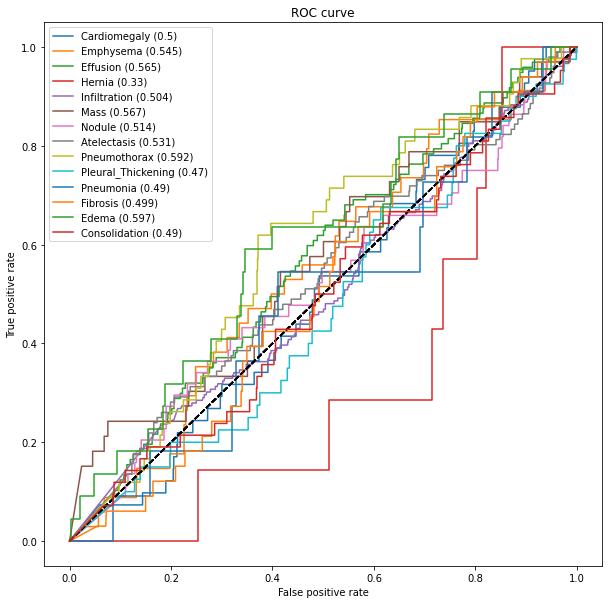

In [24]:
model.fit(train_generator, validation_data=valid_generator,steps_per_epoch=100, validation_steps=25, epochs = 10)

predicted_vals = model.predict(valid_generator, steps = len(valid_generator))

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

auc_rocs = get_roc_curve(labels, predicted_vals, valid_generator)

In [25]:
np.mean(auc_rocs)

0.5139041267104224

In [27]:
df_results['Complex Augmentation'] = auc_rocs
df_results = df_results.set_index("Condition")

In [29]:
df_results.mean()

No Augmennted Images      0.512184
Basic_Augmentation        0.502272
Multiple_Augmentations    0.513904
dtype: float64

In [36]:
df_results['No_aug'] = np.where(df_results['No Augmentation']>=0.5,1,0)
df_results['B_aug'] = np.where(df_results['Basic Augmentation']>=0.5,1,0)
df_results['C_aug'] = np.where(df_results['Complex Augmentation']>=0.5,1,0)

In [38]:
df_results.sum()

No Augmentation         7.170571
Basic Augmentation      7.031813
Complex Augmentation    7.194658
No_aug                  7.000000
B_aug                   8.000000
C_aug                   9.000000
dtype: float64